<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXRAINBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import math
import numpy as np
import pandas as pd
import warnings
from datetime import date, timedelta
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [102]:
# Define the target FX symbol: 
# 15 symbols available: 
# USDJPY, USDCHF, USDCAD, NZDUSD, GBPUSD, GBPJPY, EURJPY, EURGBP, EURCHF, EURCAD, CHFJPY,  AUDUSD, AUDJPY
symbol = 'EURUSD'
data = '/content/drive/MyDrive/data/FX/{symbol}60.csv'.format(symbol=symbol)
volumeAdjFactor = 1
drop_before = '2012-01-01'

In [103]:
#read data
df = pd.read_csv(data, sep='\t', parse_dates=True)

if 'Time' in df.columns:
  df['Date'] = df['Time']
  df.drop('Time', axis=1, inplace=True)
elif 'datetime' in df.columns:
  df['Date'] = df['datetime']
  df.drop('datetime', axis=1, inplace=True)
# capitalize the first letter in columns (if necessary)
df.columns = pd.Series(df.columns.str.capitalize())
df.index = pd.to_datetime(df['Date'])
# Adjust volumes (if necessary)
df['Volume'] = (df['Volume'])*volumeAdjFactor
df = df[df.index.dayofweek < 5]
# drop unamed (if it exists)
dropUnamed = True if 'Unnamed: 0' in df.columns else False # if the dataset contains unamed column
if dropUnamed:
  df.drop('Unnamed: 0', axis=1, inplace=True)
# drop before drop_before
df = df[~(df['Date'] < drop_before)]
df.head()

,Open,High,Low,Close,Volume,Date
Date,,,,,,
2012-01-02 00:00:00,1.29450,1.29450,1.29381,1.29397,1085,2012-01-02 00:00:00
2012-01-02 01:00:00,1.29396,1.29397,1.29288,1.29316,1510,2012-01-02 01:00:00
2012-01-02 02:00:00,1.29319,1.29419,1.29234,1.29259,1560,2012-01-02 02:00:00
2012-01-02 03:00:00,1.29259,1.29290,1.29204,1.29219,2273,2012-01-02 03:00:00
2012-01-02 04:00:00,1.29219,1.29339,1.29214,1.29295,1650,2012-01-02 04:00:00


# Add RSI MACD

In [104]:
# constants
period = 14
macd_slow = 26*8
macd_fast = 12*8
macd_smooth = 9*8
rsi_period = 14

def get_macd(df, slow, fast, smooth):
    exp1_8 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow, adjust = False).mean()
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna()
    df['rsi'] = rsi_df[3:]
    return df

In [105]:
df = get_macd(df, macd_slow, macd_fast, macd_smooth)
df = get_rsi(df, rsi_period)

# Calculate max profit on each point and determine potential entry points


In [106]:
# Standard Deviation 
df['Change'] = (df['Close']-df['Close'].shift(-1))/df['Close'].shift(-1)
# compute the risk (std) and the target rate
risk = df['Change'].std(skipna=True)
df.drop('Change', axis = 1, inplace=True)
# Define risk reward ratio
risk_factor = 4
target_rate = risk*risk_factor
print(target_rate)

0.004077740714826647


In [107]:
max_duration = 8 # in periods or laggs (for example 30min* 8 = 240min = 4 hours)
# get prices
highest_prices = df['Close']
lowest_prices = df['Close']
# calculte rolling min and max prices (after the possible entrypoints)
next_highest_prices = highest_prices.rolling(max_duration).max().shift(-max_duration)
next_lowest_prices = lowest_prices.rolling(max_duration).min().shift(-max_duration)
# Filter entrypoints before building the model
df['max_price'] = ((next_highest_prices - df['Close']) / df['Close'])
df['min_price'] = ((next_lowest_prices - df['Close']) / df['Close'])
# drop the last (max_duration) rows
df = df[:-max_duration]
# generate signals for the training dataset
# signal positive if the max price is above the target rate and the min price is above the risk 
df['tsignal'] = df.apply(lambda row: 1 if (row['max_price'] >= target_rate and row['min_price'] > -risk) else 0, axis =1)
df['atsignal'] = df.apply(lambda row: -1 if (row['min_price'] <= -target_rate and row['max_price'] < risk) else 0, axis =1)
df['tsignal'].loc[df.tsignal==0] = df.loc[df.tsignal==0]['atsignal']
# drop nans after replacing infinity
df['Volume'].replace(0, np.nan, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [108]:
# filter weak signals (insuffisant volume)
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

average_trade_volume = reject_outliers(df.loc[(df.tsignal == 1) | (df.tsignal == -1)].Volume, m=2).mean()
#df['tsignal'].loc[df.Volume<average_trade_volume] = 0
average_trade_volume

10370.496193353474

# Get the strategy validation parameters
These parameters will be implemented to our EA and tested on MT5

In [109]:
# BUY SETUP 
buysignals = df.loc[df['tsignal']==1]
entry_rsi = [buysignals['rsi'].min(), buysignals['rsi'].max()]
entry_macd = [buysignals['macd8'].min(), buysignals['macd8'].max()]
entry_macd_signal = [buysignals['signal8'].min(), buysignals['signal8'].max()]
entry_macd_histo = [buysignals['hist8'].min(), buysignals['hist8'].max()]
entry_buy_volume = [buysignals['Volume'].min(), buysignals['Volume'].max()]

print('BUY entry RSI:', entry_rsi)
print('BUY entry MACD:', entry_macd)
print('BUY entry MACD SIGNAL:', entry_macd_signal)
print('BUY entry MACD HISTO', entry_macd_histo)
print('BUY entry VOLUME', entry_buy_volume)

print('**************************')


# SELL SETUP 
sellsignals = df.loc[df['tsignal']==-1]
entry_rsi = sellsignals['rsi'].max()
entry_macd = sellsignals['macd8'].max()
entry_macd_signal = sellsignals['signal8'].max()
entry_macd_histo = sellsignals['hist8'].max()
entry_sell_volume = buysignals['Volume'].min()

print('SELL entry RSI:', entry_rsi)
print('SELL entry MACD:', entry_macd)
print('SELL entry MACD SIGNAL:', entry_macd_signal)
print('SELL entry MACD HISTO', entry_macd_histo)

BUY entry RSI: [12.400672436230238, 89.75280416763509]
BUY entry MACD: [-0.016720180038942933, 0.012525871051646265]
BUY entry MACD SIGNAL: [-0.015113203543984917, 0.01135431562885988]
BUY entry MACD HISTO [-0.005651277704195668, 0.005364234173000852]
BUY entry VOLUME [141, 118728]
**************************
SELL entry RSI: 94.22364189652018
SELL entry MACD: 0.012621494589872162
SELL entry MACD SIGNAL: 0.011454762562294022
SELL entry MACD HISTO 0.005448070856552427


##Plot the signals

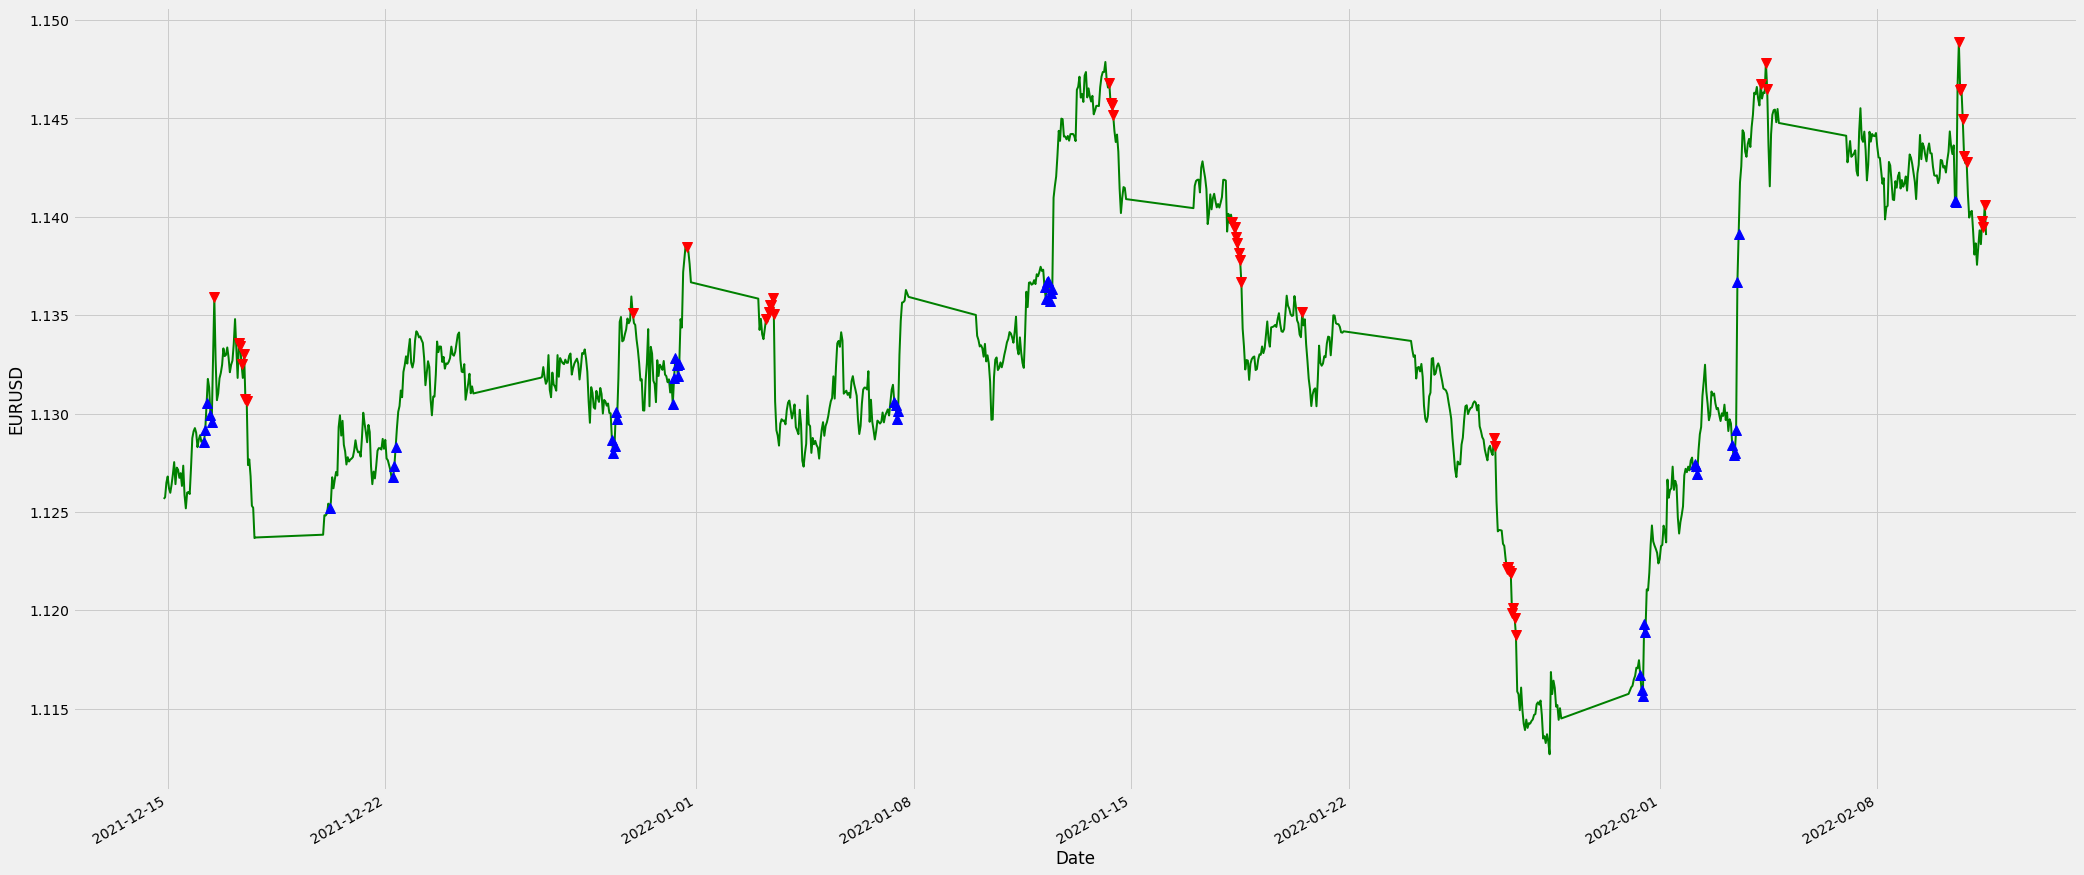

In [111]:
# Reduce the data
ddf = df[-1000:]
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel=symbol)

## Plot the closing price
ddf['Close'].plot(ax=ax1, color='g', lw=2.)

# Plot the buy signals
ax1.plot(ddf.loc[ddf.tsignal == 1.0].index, 
         ddf.Close[ddf.tsignal == 1.0],
         '^', markersize=10, color='b')

# Plot the sell signals
ax1.plot(ddf.loc[ddf.tsignal == -1.0].index, 
         ddf.Close[ddf.tsignal == -1.0],
         'v', markersize=10, color='r')
# Show the plot
plt.show()